# Importing Libaries:

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [13]:
dataset = keras.utils.image_dataset_from_directory(
    "../celeb_data/data/",
    label_mode=None,
    image_size=(64,64),
    batch_size=32,
    smart_resize=True
)

Found 4920 files belonging to 1 classes.


In [14]:
dataset = dataset.map(lambda x: x/255.)

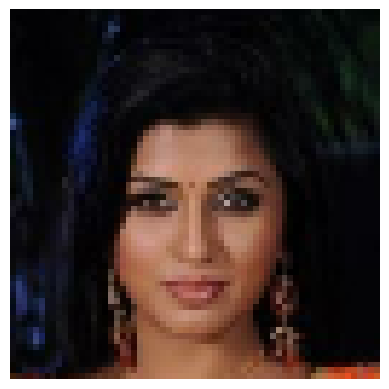

In [15]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy()*255).astype("int32")[0])
    break

### Discriminator

In [2]:
# output layers with one nueron and sigmoid activation because it is a classifier,
# that classifies real and fake images.

In [16]:
def discriminator():
    """
    Discriminator model for adversarial training.

    This function defines a discriminator model that takes an input image of shape (64, 64, 3) and outputs a probability
    indicating whether the input image is real or fake.

    Returns:
        keras.Model: The discriminator model.
    """
    input = keras.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, kernel_size = 4, strides= 2, padding ="same")(input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size = 4, strides= 2, padding ="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size = 4, strides= 2, padding ="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    discriminator_output = layers.Dense(1, activation="sigmoid")(x)
    discriminator = keras.Model(input, discriminator_output)

    return discriminator

In [17]:
discriminator = discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0     

### Generator:

In [18]:
latent_dim = 128

1. Output units =3: In color images, each pixel is represented by three values corresponding to the intensities of the red, green, and blue channels (RGB). Therefore, to generate a full-color image, the output layer of the generator needs to produce values for each of these channels.
2.  Hence, there are three units in the output layer, each representing one of the RGB channels.

3. Sigmoid Activation: The sigmoid activation function is commonly used in the output layer of a generator network for image generation tasks because it scales the output values to the range [0, 1]. In the context of RGB images, this range corresponds to valid pixel intensity values.
4. By using the sigmoid activation function, the generator can output pixel values that are within the valid range for each RGB channel.

In [21]:
def generator():
    """
    Generator model for generating synthetic images.

    This function defines a generator model that takes a latent vector as input and generates synthetic images
    of shape (64, 64, 3).

    Returns:
        keras.Model: The generator model.
    """
    latent_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 128)(latent_input)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    generator_output = layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid")(x)
    generator = keras.Model(latent_input, generator_output)

    return generator

In [22]:
generator = generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                 

### The adversarial network

In [23]:
class GAN(keras.Model):
    """
    Generative Adversarial Network (GAN) model.

    This class represents a GAN model consisting of a discriminator and a generator.

    Args:
        discriminator (keras.Model): The discriminator model.
        generator (keras.Model): The generator model.
        latent_dim (int): The dimensionality of the latent space.

    Attributes:
        discriminator (keras.Model): The discriminator model.
        generator (keras.Model): The generator model.
        latent_dim (int): The dimensionality of the latent space.
        d_loss_metric (keras.metrics.Mean): Metric to track the discriminator loss during training.
        g_loss_metric (keras.metrics.Mean): Metric to track the generator loss during training.
    """
    def __init__(self, discriminator, generator, latent_dim):
        """
        Initialize the GAN model.

        Args:
            discriminator (keras.Model): The discriminator model.
            generator (keras.Model): The generator model.
            latent_dim (int): The dimensionality of the latent space.
        """
        # super is required to initialize the keras.Model in th GAN class.
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Configure the GAN model for training.

        Args:
            d_optimizer: The optimizer for the discriminator.
            g_optimizer: The optimizer for the generator.
            loss_fn: The loss function to use.
        """
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        """
        Return custom metrics to track during training.

        Returns:
            list: List of metrics to track.
        """
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        """
        Perform a single training step for the GAN model.

        Args:
            real_images: Input batch of real images.

        Returns:
            dict: Dictionary containing the updated loss metrics.
        """
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors)
            )
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }


In [25]:
class GANMonitor(keras.callbacks.Callback):
    """
    Callback for monitoring and saving generated images during training of a GAN model.

    This callback generates and saves images at the end of each training epoch.

    Args:
        num_img (int, optional): Number of images to generate and save at the end of each epoch. Defaults to 3.
        latent_dim (int, optional): Dimensionality of the latent space. Defaults to 128.

    Attributes:
        num_img (int): Number of images to generate and save at the end of each epoch.
        latent_dim (int): Dimensionality of the latent space.
    """
    def __init__(self, num_img=3, latent_dim=128):
        """
        Initialize the GANMonitor callback.

        Args:
            num_img (int, optional): Number of images to generate and save at the end of each epoch. Defaults to 3.
            latent_dim (int, optional): Dimensionality of the latent space. Defaults to 128.
        """
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback function called at the end of each epoch.

        Generates and saves images.

        Args:
            epoch (int): Current epoch number.
            logs: Dictionary of logs containing the loss value.
        """
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        if not os.path.exists("generated_images"):
            os.makedirs("generated_images")
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(os.path.join("generated_images",f"generated_img_{epoch:03d}_{i}.png"))

# Training the GAN

In [27]:
epochs = 100

In [28]:
gan = GAN(discriminator=discriminator, generator=generator,latent_dim=latent_dim)

In [29]:
gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn = keras.losses.BinaryCrossentropy()
)

In [43]:
gan.fit(dataset,epochs=epochs,callbacks=[GANMonitor(num_img=10,latent_dim=latent_dim)])

Epoch 1/100


154/154 [==============================] - 70s 393ms/step - d_loss: 0.4543 - g_loss: 1.4810
Epoch 2/100
154/154 [==============================] - 56s 366ms/step - d_loss: 0.5303 - g_loss: 1.4953
Epoch 3/100
154/154 [==============================] - 56s 366ms/step - d_loss: 0.5217 - g_loss: 1.4897
Epoch 4/100
154/154 [==============================] - 57s 367ms/step - d_loss: 0.6611 - g_loss: 1.4162
Epoch 5/100
154/154 [==============================] - 57s 367ms/step - d_loss: 0.4996 - g_loss: 1.5834
Epoch 6/100
154/154 [==============================] - 57s 368ms/step - d_loss: 0.6532 - g_loss: 1.8101
Epoch 7/100
154/154 [==============================] - 57s 368ms/step - d_loss: 0.5934 - g_loss: 0.9402
Epoch 8/100
154/154 [==============================] - 57s 369ms/step - d_loss: 0.5457 - g_loss: 1.4947
Epoch 9/100
154/154 [==============================] - 57s 368ms/step - d_loss: 0.6348 - g_loss: 0.9869
Epoch 10/100
154/154 [==============================] - 56s 365ms/step - d_l